# PyVG: Data Science to predict Video Games sales
>Equipe: Alexis Terrasse, Henri-François Mole, Hsan Drissi, Stephane Lelievre
>
>Promo: DS_Oct21
---
## Mise en application - Diablo IV

<img src='https://media0.giphy.com/media/XYBIGvYOaOfqE/giphy.gif'></img>

<p> Pour cette partie nous verrons pour prédire les ventes du jeu Diblo IV dont la sortie est prévue pour fin 2022</p>

### Importation des bibliothèques

In [1]:
#Importation des bibliothèques
import pandas as pd 
from tqdm import tqdm

import praw
import logins
from praw.models import MoreComments

import gensim
from gensim.models import KeyedVectors
import gensim.downloader as api

import os

import requests, zipfile
from io import BytesIO
import h5py

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Importation des fonctions utilitaires

In [2]:
#from nlp_utils import *
from utils2 import *

### Récupération des informations de disponibles

<table>
        <tr>
            <td><img src="https://www.guinnessworldrecords.com/Images/vgchartz-760x444_tcm25-607263.jpg?ezimgfmt=rs:412x241/rscb1/ng:webp/ngcb1" alt="" width='300'/></td>
            <td><img src="https://seekvectorlogo.com/wp-content/uploads/2020/06/metacritic-vector-logo.png" alt="" width='300'/></td>
        </tr>
</table>


In [3]:
# Création du dataframe dans lequel nous stockerons les données de Diablo IV

diablo4_df= pd.DataFrame(columns= ['Name',
                        'Platform',
                        'Genre',
                        'Global_Sales',
                        'game_key',
                        'Name_meta',
                        'Genre_meta',
                        'Score_pro',
                        'Score_user',                 
                        'Publisher',
                        'Developer',
                        'N_pro',
                        'N_user',
                        'day',
                        'year',
                        'month',
                        'release_date',
                        'quarter',
                        'Franchise_wikipedia',
                        'compound'])

Genre= 'Action' # Genre répertorié pour Diablo IV sur VgChartz
Global_Sales= np.nan # NaN à déterminer à la fin
game_key= 'diablo-iv' 
Score_pro= np.nan # A estimer
Score_user= np.nan # A estimer
N_pro = 1 #Valeur par défaut
N_user= np.nan # Nb comments reddit
day= 1 # par défaut
year= 2022 # année de sortie prévue
month= 12 #par défaut
release_date= 'TBC' # Inconnue (non utilisée)
quarter= 4.0 # Par défaut
Franchise_wikipedia= 'Diablo' # Franchise du jeu
compound= np.nan # A estimer

# Récupération des données du jeu depuis Metacritic
i= 0
for plat in ['pc', 'xbox-one', 'playstation-4']:
    
    Name, Platform, release, Publisher, Developer, Genre_meta= scrap_meta_info('https://www.metacritic.com/game/'+plat+'/diablo-iv')
    
    diablo4_df.loc[i]= [Name,
                        Platform,
                        Genre,
                        Global_Sales,
                        game_key,
                        Name,
                        Genre_meta,
                        Score_pro,
                        Score_user,                 
                        Publisher,
                        Developer,
                        N_pro,
                        N_user,
                        day,
                        year,
                        month,
                        release_date,
                        quarter,
                        Franchise_wikipedia,
                        compound]
    i+=1

diablo4_df

,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,Developer,N_pro,N_user,day,year,month,release_date,quarter,Franchise_wikipedia,compound
0,Diablo IV,PC,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,NaN,Activision,Blizzard Entertainment,1,NaN,1,2022,12,TBC,4.0,Diablo,NaN
1,Diablo IV,Xbox One,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,NaN,Activision,Blizzard Entertainment,1,NaN,1,2022,12,TBC,4.0,Diablo,NaN
2,Diablo IV,PlayStation 4,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,NaN,Activision,Blizzard Entertainment,1,NaN,1,2022,12,TBC,4.0,Diablo,NaN


### Récupération des commentaires Reddit

<p>Nous utiliserons l'API Reddit (PRAW) afin de récupérer les commentaires concernant Diablo IV et ainsi estimer le Score_user et le N_user</p>

<img src='https://stuff.co.za/wp-content/uploads/2021/09/reddit_logo_main.jpg' width='300'></img>

#### Prédictions de Score_user et récupération de N_user

In [4]:
# Identification à l'API PRAW
reddit = praw.Reddit(client_id=logins.client_id, client_secret= logins.client_secret, user_agent=logins.user_agent)

# Choix du subreddit
subreddit= 'diablo4'

# Récupération de tous les threads du subreddit choisi
subr = []
game_subreddit = reddit.subreddit(subreddit)
for post in game_subreddit.top(limit=300):
    subr.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
subr = pd.DataFrame(subr,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

# Affichage des dimensions de subr
print('Dimension de subr:',subr.shape)
#Affichage des 5 1ere lignes
subr.head()

Dimension de subr: (300, 8)


,title,score,id,subreddit,url,num_comments,body,created
0,The most disgusting duo,644,odi97a,diablo4,https://i.redd.it/6gyd2zvzg6971.png,17,,1.625397e+09
1,The beating heart of a Diablo game.,345,drlb2m,diablo4,https://www.reddit.com/r/diablo4/comments/drlb...,190,**Is itemization.**\n\nIf you want to know why...,1.572890e+09
2,Watching the Diablo Q&A,322,lp97sd,diablo4,https://i.redd.it/hpey04wixwi61.png,71,,1.613949e+09
3,New Hero!,290,l2ah9s,diablo4,https://i.redd.it/31vxmf30rrc61.png,26,,1.611271e+09
4,Hope & Desire,248,pgxzce,diablo4,https://i.redd.it/mozqg0qit7l71.jpg,73,,1.630643e+09


In [5]:
# Instanciation du DataFrame full_comments
full_comments= pd.DataFrame()

# Récupération de tous les commentaires présents dans chaque thread du subreddit
for sub in tqdm(subr['id'],desc='Récupération de tous les posts'):
    submission = reddit.submission(id=sub)
    comments=[]
    submission.comments.replace_more(limit=None)
    comment_queue = submission.comments[:]  
    while comment_queue:

        comment = comment_queue.pop(0)
        comments.append(comment.body)
        comment_queue.extend(comment.replies)

    comments= pd.DataFrame(comments, columns=['Comments'])
        
    full_comments= pd.concat([full_comments,comments])
    
# Suppression des duplicatas
full_comments.drop_duplicates(keep='first', inplace=True)

# On compte le nombre de mots de chaque comments et on l'enregistre dans la colonne n_words
full_comments['n_words']= full_comments['Comments'].apply(lambda x: len(x.split()) )

# On ne conserve que les comments avec plus de 5 mots
full_comments= full_comments[full_comments['n_words']>5]

# Affichage des dimensions de full_comments
print('Dimension de full_comments:',full_comments.shape)

# Affichage des 5 premières lignes de full_comments
full_comments.head()

Récupération de tous les posts: 100%|██████████| 300/300 [13:08<00:00,  2.63s/it]

Dimension de full_comments: (9907, 2)


,Comments,n_words
0,Did they answer or delete it?,6
3,Is the guy banned from Twitter yet ? 😂😂,9
4,Is there a subreddit of people setting themsel...,22
10,"Lmao. On the other hand though, how can you ca...",19
16,Yeah the fat zombie looks kinda cute in the sc...,11


In [6]:
## Chargement ou telechargement du modèle word2vec-google-news-300

# Récupération du chemin de téléchargement du modèle en local
path= gensim.downloader.BASE_DIR+'/word2vec-google-news-300/word2vec-google-news-300.gz'

#Si le fichier n'existe pas on le télécharge avec l'api
if not os.path.exists(path) :
    print('Téléchargement des données ...')
    api.load("word2vec-google-news-300")
    
# Chargement du modèle limité aux 350 000 mots les plus fréquents 
emb_model = KeyedVectors.load_word2vec_format(path, binary=True, limit=350000)  
print('Modèle de Word Embedding pré-entrainé chargé !')

# On stocke le vocabulaire dans vocab
vocab = emb_model.index_to_key

# On instancie un objet Tokenizer (keras.preprocessing.text)
t = Tokenizer()

# On récupère tous les mots de notre vocabulaire sous forme de liste
all_words=list(vocab)

# On calcule la taille de notre vocabulaire (on ajoute +1 pour la réservation de l'index 0)
vocab_size = len(all_words) +1

# On 'fit' le Tokenizer avec la liste de mots
t.fit_on_texts(all_words)

Modèle de Word Embedding pré-entrainé chargé !


In [7]:
# On choisi maxlen = 500 (le nombre de mots max à prendre en compte)
maxlen= 500

# Les mots sont remplacés par leur index 
full_comments_seq=t.texts_to_sequences(full_comments['Comments'])

# Si le commentaire fait moins de 500 mots on le comble avec des 0
full_comments_emb = pad_sequences(full_comments_seq, padding='post', maxlen=maxlen)

In [8]:
# Chargement de notre model d'analyse de sentiments depuis dropbox

# Url et nom du fichier
url= 'https://www.dropbox.com/s/nu0z6kb706k99zy/emb_conv1dnn.zip?dl=1'
filename = url.split('/')[-1]

# Requête au serveur
req = requests.get(url)

# récupération du zip
zipfile= zipfile.ZipFile(BytesIO(req.content))

# Extraction du zip
print('Téléchargement du modèle pour l\'analyse de sentiments')
for file in zipfile.infolist():
    model_h5_file = zipfile.open(file)
    
# Chargement du modèle
emb_conv1dnn= tf.keras.models.load_model(h5py.File(model_h5_file, 'r'))
print('Modèle d\'analyse de sentiments chargé !\n')

# Affichage du sommaire du modèle
emb_conv1dnn.summary()

Téléchargement du modèle pour l'analyse de sentiments
Modèle d'analyse de sentiments chargé !

Model: "Emb-Conv1DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          105000300 
                                                                 
 conv1d (Conv1D)             (None, 496, 250)          375250    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dense_1 (Dense)             (None, 11)                2761      
                                                                 
Total params: 105,441,061

In [9]:
# Prediction des scores sur les commentaires reddit
preditct= emb_conv1dnn.predict(full_comments_emb)

# Conversion du vecteur de probabilités par la classe la classe correspondante
preditct_class= np.argmax(preditct,axis=1)

# On stocke la moyenne de toutes les notes (arrondie) dans la variable Score_user
Score_user= round(preditct_class.mean(),2)

# On stocke également le nombre de commentaires dans N_user
N_user= len(full_comments)
print('Le Score_user prédit par notre modèle est de :', Score_user)

Le Score_user prédit par notre modèle est de : 4.52


In [10]:
# Choix de deux indices au hasard
rd_idx = np.random.randint(len(full_comments), size=2)

# Affichage du commentaire correspondant et de la note prédite pour chacun
for idx in rd_idx: 
    print('Comment: ',full_comments['Comments'].iloc[idx],'\n')
    print('Score prédit: ', preditct_class[idx],'\n')

Comment:  Completely agree, we are usually 5-6 people playing D3 every new season and it just makes everything less efficient.

I see no real reason not to have 6 or 8 player groups, if its about console then just lock console groups to 4... 

Score prédit:  4 

Comment:  He talks about what he loves and dislike about diablo2. What makes the game so good and what current games maby are missing.

You can tell he's been thinking about this. And I think many game developers can get some inspiration. 

Score prédit:  9 



In [11]:
# On modifie les valeurs de Score_user et N_user par celles que l'on vient d'estimer
diablo4_df['Score_user']= Score_user
diablo4_df['N_user']= N_user

# Affichage de diablo4_df mis à jour
diablo4_df

,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,Developer,N_pro,N_user,day,year,month,release_date,quarter,Franchise_wikipedia,compound
0,Diablo IV,PC,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,NaN
1,Diablo IV,Xbox One,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,NaN
2,Diablo IV,PlayStation 4,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,NaN


### Détermination du compound

<p> On utilisera à nous les commentaires récupérés sur Reddit pour estimer la variable compound qui est obtenue à l'aide de l'objet SentimentIntensityAnalyzer de la bibliothèque vaderSentiment</p>

In [12]:
# Instanciation d'un objet SentimentIntensityAnalyzer de la bibliothèque vaderSentiment
sentiment_intensity_analyzer = SentimentIntensityAnalyzer()

# Calcule des scores de sentiments avec vader
full_comments['vader_score'] = full_comments['Comments'].apply(lambda x: list(sentiment_intensity_analyzer.polarity_scores(x).values()))
full_comments[['neg','neu','pos','compound']] = pd.DataFrame(full_comments['vader_score'].tolist(), columns=['neg','neu','pos','compound'])
full_comments.drop(['vader_score','n_words'],inplace=True,axis=1)
full_comments.head()

,Comments,neg,neu,pos,compound
0,Did they answer or delete it?,0.000,1.000,0.000,0.0000
3,Is the guy banned from Twitter yet ? 😂😂,0.128,0.604,0.268,0.5719
4,Is there a subreddit of people setting themsel...,0.000,0.509,0.491,0.7722
10,"Lmao. On the other hand though, how can you ca...",0.069,0.798,0.133,0.9279
16,Yeah the fat zombie looks kinda cute in the sc...,0.046,0.747,0.206,0.9960


In [13]:
# On calcule la moyenne des compound pour l'ensemble des commentaires et on la stocke dans compound
compound= full_comments['compound'].mean()

# Affichage du compound
print('La valeur du compound prédite est:',compound)

La valeur du compound prédite est: 0.4729377107095934


In [14]:
# On affecte la valeur compound à notre dataframe diablo4_df
diablo4_df['compound']= compound

# Affichage de diablo4_df mis à jour
diablo4_df

,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,Developer,N_pro,N_user,day,year,month,release_date,quarter,Franchise_wikipedia,compound
0,Diablo IV,PC,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938
1,Diablo IV,Xbox One,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938
2,Diablo IV,PlayStation 4,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938


### Prédiction du Score_pro

<p> Pour la prédiction du Score_pro on utilisera le dataframe principale auquel on retirera la variable Global_sales et on instanciera un modèle XGBoost Regressor dont la cible sera cette fois Score_pro.</p>

In [15]:
# On map les modalités de Platform pour qu'elles correspondent à celle de notre jeu de données vgsales_eda2.csv
diablo4_df['Platform']= diablo4_df['Platform'].map({'PC':'PC',                                             
                                                    'PlayStation 4':'PS4',
                                                    'Xbox One':'XOne'})
diablo4_df

,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,Developer,N_pro,N_user,day,year,month,release_date,quarter,Franchise_wikipedia,compound
0,Diablo IV,PC,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938
1,Diablo IV,XOne,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938
2,Diablo IV,PS4,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",NaN,4.52,Activision,Blizzard Entertainment,1,9907,1,2022,12,TBC,4.0,Diablo,0.472938


In [16]:
df = lire()
df[df['Global_Sales'] <= 40]

dataset shape: (8937, 20)
columns: Index(['Name', 'Platform', 'Genre', 'Global_Sales', 'game_key', 'Name_meta',
       'Genre_meta', 'Score_pro', 'Score_user', 'Publisher', 'Developer',
       'N_pro', 'N_user', 'day', 'year', 'month', 'release_date', 'quarter',
       'Franchise_wikipedia', 'compound'],
      dtype='object')
dataset shape ([2001 ; 2018]): (8654, 20)


,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,Developer,N_pro,N_user,day,year,month,release_date,quarter,Franchise_wikipedia,compound
0,Grand Theft Auto: San Andreas,PS2,Action,20.81,grand-theft-auto-san-andreas,Grand Theft Auto: San Andreas,"Action Adventure, Modern",9.5,9.1,rockstar games,Rockstar North,80,3015,26,2004,10,2004-10-26,4.0,Grand theft Auto,0.426416
1,Grand Theft Auto: San Andreas,XB,Action,1.95,grand-theft-auto-san-andreas,Grand Theft Auto: San Andreas,"Action Adventure, Modern",9.3,8.8,rockstar games,Rockstar North,58,187,7,2005,6,2005-06-07,2.0,Grand theft Auto,0.473079
2,Grand Theft Auto: San Andreas,PC,Action,0.97,grand-theft-auto-san-andreas,Grand Theft Auto: San Andreas,"Action Adventure, Modern, Modern, Open-World",9.3,8.9,rockstar games,Rockstar North,47,3774,7,2005,6,2005-06-07,2.0,Grand theft Auto,0.470357
3,Grand Theft Auto V,PS3,Action,20.32,grand-theft-auto-v,Grand Theft Auto V,"Modern, Action Adventure, Modern, Open-World",9.7,8.3,rockstar games,Rockstar North,50,4829,17,2013,9,2013-09-17,3.0,Grand theft Auto,0.684974
4,Grand Theft Auto V,PS4,Action,19.39,grand-theft-auto-v,Grand Theft Auto V,"Action Adventure, Modern, Open-World",9.7,8.4,rockstar games,Rockstar North,66,7079,18,2014,11,2014-11-18,4.0,Grand theft Auto,0.676964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8929,Zero Escape: Virtue's Last Reward,PSV,Visual+Novel,0.00,zero-escape-virtue-s-last-reward,Zero Escape: Virtue's Last Reward,"Adventure, General, General, Visual Novel",8.4,8.8,aksys games,ChunSoft,32,279,23,2012,10,2012-10-23,4.0,Zero Escape,0.581066
8930,Root Letter,PS4,Visual+Novel,0.03,root-letter,Root Letter,"Adventure, Visual Novel",6.8,7.0,pqube,Kadokawa,16,25,8,2016,11,2016-11-08,4.0,Root Letter,0.261619
8933,428: Shibuya Scramble,PS4,Visual+Novel,0.02,428-shibuya-scramble,428: Shibuya Scramble,"Action Adventure, Adventure, General, Visual N...",8.5,7.7,spike chunsoft,Spike Chunsoft,19,4,4,2018,9,2018-09-04,3.0,Scramble,0.517235
8934,Chaos;Child,PS4,Visual+Novel,0.02,chaos-child,Chaos;Child,"Adventure, General, Visual Novel",7.6,8.4,5pb,5pb,18,9,17,2017,10,2017-10-17,4.0,Chaos;Child,0.492058


In [17]:
df = lire() # Chargement du dataframe vgsales_eda2.csv
df= df[df['Global_Sales'] <= 30] # Suppression des outliers
df = supprimer_val_aberrantes(df) # Pré-processing de df

# Ajout des lignes de Diablo IV pour effectuer les transformations sur le dataframe
df= pd.concat([df, diablo4_df], ignore_index=True)

df = enlever_date_ref(df) # Suppression des dates

# On force le type de N_pro et N_user en type int
df['N_pro']= df['N_pro'].astype(int) 
df['N_user']= df['N_user'].astype(int)

df = ajoute_oem(df) # Ajout des oem (PC, Playstation, nintendo ...)

df = ajoute_dummies(df) # Création des dummies des variables catégorielles

dataset shape: (8937, 20)
columns: Index(['Name', 'Platform', 'Genre', 'Global_Sales', 'game_key', 'Name_meta',
       'Genre_meta', 'Score_pro', 'Score_user', 'Publisher', 'Developer',
       'N_pro', 'N_user', 'day', 'year', 'month', 'release_date', 'quarter',
       'Franchise_wikipedia', 'compound'],
      dtype='object')
dataset shape ([2001 ; 2018]): (8654, 20)


In [18]:
# On retire de df les dernières lignes concernant Diablo 4 et on les stockent dans diablo4_df
diablo4_df= df.iloc[-3:,:]
diablo4_df['pub_activision']= 1 # On force pub_activision à 1 dans la mesure où ils s'agit d'un jeu Activision-Blizzard

# On retire les lignes de diablo4_df de df
df= df.iloc[:-3,:]

# Sélection des features
data= df.select_dtypes(exclude='object').drop(['Global_Sales','Score_pro',
                                               'year.release_2001', 'year.release_2002',
                                               'year.release_2003', 'year.release_2004', 'year.release_2005',
                                               'year.release_2006', 'year.release_2007', 'year.release_2008',
                                               'year.release_2009', 'year.release_2010', 'year.release_2011',
                                               'year.release_2012', 'year.release_2013', 'year.release_2014',
                                               'year.release_2015', 'year.release_2016', 'year.release_2017',
                                               'year.release_2018', 'year.release_2022',
                                              ],axis=1)

# Sélection de la target
target= df['Score_pro']

C:\Users\Furynx\AppData\Local\Temp/ipykernel_30696/4120785500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diablo4_df['pub_activision']= 1 # On force pub_activision à 1 dans la mesure où ils s'agit d'un jeu Activision-Blizzard


In [19]:
# Séparation du jeu de données en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.20, random_state=0)
print('Dimensions de X_train:', X_train.shape)
print('Dimensions de X_test:', X_test.shape)

# Préparation des données à prédire pour Diablo IV
to_pred= diablo4_df.select_dtypes(exclude='object').drop(['Global_Sales','Score_pro',
                                                          'year.release_2001', 'year.release_2002',
                                                          'year.release_2003', 'year.release_2004', 'year.release_2005',
                                                          'year.release_2006', 'year.release_2007', 'year.release_2008',
                                                          'year.release_2009', 'year.release_2010', 'year.release_2011',
                                                          'year.release_2012', 'year.release_2013', 'year.release_2014',
                                                          'year.release_2015', 'year.release_2016', 'year.release_2017',
                                                          'year.release_2018', 'year.release_2022'                                                         
                                                         ],axis=1)


Dimensions de X_train: (6780, 48)
Dimensions de X_test: (1696, 48)


In [20]:
# Instanciation d'un objet RepeatedKFold pour la Cross-Validation
cv = RepeatedKFold(n_splits=8, n_repeats=3, random_state=1)

# Instanciation d'un modèle XGBoost
xgbr= XGBRegressor(n_estimators=2000, max_depth=8, eta=0.01, subsample=0.6, colsample_bytree=0.8)

# Entraintement du modèle
xgbr.fit(X_train, y_train)

# Affichage des résultats du modèle
print('Coefficient de détermination du modèle :', xgbr.score(X_train, y_train))
#print('Coefficient de détermination obtenu par Cv :', cross_val_score(xgbr,X_train,y_train,scoring='r2', cv=cv, n_jobs=-1).mean())
print('score du modèle sur l ensemble de test : ', xgbr.score(X_test, y_test))

Coefficient de détermination du modèle : 0.9364876424508715
score du modèle sur l ensemble de test :  0.7134193226834452


In [21]:
# Prédiction des résultats pour le jeu de test 
y_pred= xgbr.predict(X_test)

# Affichage/comparaison valeurs réelles/prédites sur le jeu de test (10 premières lignes)
pd.DataFrame(zip(y_pred, y_test), columns=['Prédit', 'Réel']).head(10)

,Prédit,Réel
0,8.210966,7.6
1,7.959344,7.6
2,6.928669,7.8
3,8.164077,8.0
4,9.096841,9.7
5,7.039216,7.2
6,6.382072,5.2
7,8.870721,8.4
8,7.200968,8.2
9,7.852462,8.1


In [22]:
# Prédiction des Scores pro pour Diablo IV
d4_pred= xgbr.predict(to_pred)

In [23]:
# Ajout des valeurs Score_pro au dataframe diablo4_df
i=0
for index in diablo4_df.index:
    diablo4_df['Score_pro'].loc[index]= round(d4_pred[i],2)
    i+=1
    
# Affichage de diablo4_df mis à jour
diablo4_df

C:\Users\Furynx\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Name,Platform,Genre,Global_Sales,game_key,Name_meta,Genre_meta,Score_pro,Score_user,Publisher,...,genre_Party,genre_Platform,genre_Puzzle,genre_Racing,genre_Role-Playing,genre_Shooter,genre_Simulation,genre_Sports,genre_Strategy,genre_Visual+Novel
8476,Diablo IV,PC,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",7.73,4.52,Activision,...,0,0,0,0,0,0,0,0,0,0
8477,Diablo IV,XOne,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",8.02,4.52,Activision,...,0,0,0,0,0,0,0,0,0,0
8478,Diablo IV,PS4,Action,NaN,diablo-iv,Diablo IV,"Role-Playing, Action RPG",7.97,4.52,Activision,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Concaténation de df et diablo4_df
df= pd.concat([df, diablo4_df], ignore_index=True)

## Prédiction de Global_sales (Régression)

<p> Maintenant que nous disposons de toutes les features nécessaires, nous pouvons effectuer une prédiction du Global_Sales avec le modèle de regression déterminé dans la partie Regression</p>

In [25]:
# Passage aux valeurs logarithmiques des variables 
df= normalise_log(df)

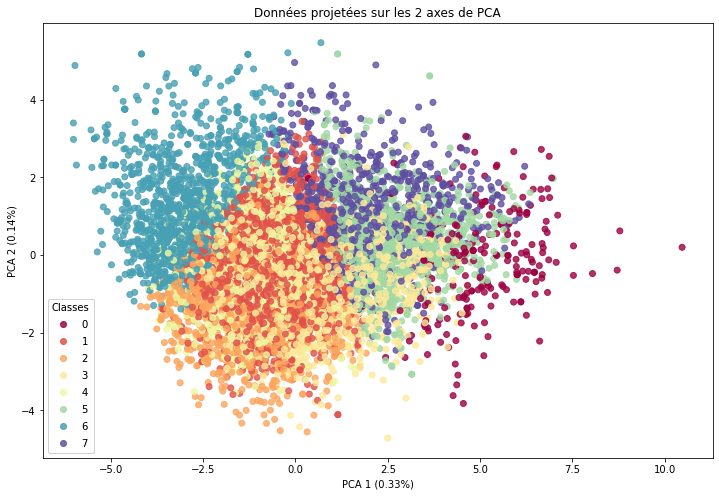

C:\Users\Furynx\AppData\Local\Temp/ipykernel_30696/4063793484.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df= df.select_dtypes(exclude='object').drop(['Global_Sales','N_pro.log', 'N_user.log', 'labels',


In [26]:
# Recherche et ajout des clusters (c=8) au sein de notre dataframe df
df= affiche_pca_cluster(df,c=8)

# Suppression des colonnes 'Global_Sales','Score_pro','Score_user','N_pro' (on garde uniquement les valeurs logarithmiques)
df= df.select_dtypes(exclude='object').drop(['Global_Sales','N_pro.log', 'N_user.log', 'labels',
                                              'year.release_2001', 'year.release_2002', 'year.release_2003',
                                             'year.release_2004', 'year.release_2005', 'year.release_2006',
                                             'year.release_2007', 'year.release_2008', 'year.release_2009',
                                             'year.release_2010', 'year.release_2011', 'year.release_2012',
                                             'year.release_2013', 'year.release_2014', 'year.release_2015',
                                             'year.release_2016', 'year.release_2017', 'year.release_2018',
                                             'year.release_2022'  
                                                                                       
                                            ],1)

In [27]:
# On sépare à nouveau les données de Diabo IV  de celles de df
diablo4_df= df.iloc[-3:,:]
df= df.iloc[:-3,:]

In [28]:
# Sélection de la target (ici la version log de Global_Sales)
target=df['Global_Sales.log']

# Sélection des features du modèle
data=df.drop('Global_Sales.log',1)

# Séparation des données en jeu d'entrainement et jeu de test
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.2, random_state= 0)

C:\Users\Furynx\AppData\Local\Temp/ipykernel_30696/2254746388.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data=df.drop('Global_Sales.log',1)


In [29]:
# On normalise les données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

diablo4_df_scaled = scaler.transform(diablo4_df.drop('Global_Sales.log',axis=1))

In [30]:
from sklearn.ensemble import RandomForestRegressor
rfr= RandomForestRegressor()
rfr.fit(X_train_scaled,y_train)

print('Coefficient de détermination du modèle :', rfr.score(X_train_scaled, y_train))
#print('Coefficient de détermination obtenu par Cv :', cross_val_score(rfr,X_train,y_train,scoring='r2', cv=5, n_jobs=-1).mean())
print('score du modèle sur l ensemble de test : ', rfr.score(X_test_scaled, y_test))

Coefficient de détermination du modèle : 0.9258079881351448
score du modèle sur l ensemble de test :  0.47988637150355906


In [31]:
d4_log_pred= rfr.predict(diablo4_df_scaled)

In [32]:
# Affichage des prédictions pour Diablo IV
sum_d4=0
d4_plat_liste= ['PC','PS4','XOne']

for elt in range(len(d4_log_pred)):
    print('Global_sales estimées sur '+d4_plat_liste[elt], round(np.exp(d4_log_pred[elt]),0))
    sum_d4+= round(np.exp(d4_log_pred[elt]),0)
print('\nGlobal_sales toutes plateformes confondues:', sum_d4)

Global_sales estimées sur PC 3983.0
Global_sales estimées sur PS4 1387187.0
Global_sales estimées sur XOne 1322043.0

Global_sales toutes plateformes confondues: 2713213.0


##### Analyse des résultats obtenus par régression

<p>La prédiction obtenue par notre modèle semble bien en-deça de ce à quoi on peut s'attendre d'une licence de jeu AAA développée par une compagnie telle que Activision Blizzard.</p>

<p>Il est probable que le modèle n'a pas su capter ici les éléments nécessaires pour faire une estimation plus fine du Global_Sales.
    
Cela peut s'expliquer par des données de qualités insuffisantes ainsi que du manque de features pertinentes.
En effet, le regroupement de nos datasets a entrainé la perte de certaines entrées pour les jeux de la même franchise (Diablo) tels que Diablo ou encore Diablo III qui représentent des millions de ventes toutes plateformes confondues.</p>

<p>On pourrait donc s'attendre à un résultat beaucoup plus élevé.</p>

## Prédiction de Global_sales (Classification)

<p> A l'instar que pour la précédente partie nous disposons des données nécessaires pour effectuer une classification des Global_Sales.</p>

In [33]:
# Séparer les variables explicatives de la variable à prédire
bins=8
target = pd.qcut(df['Global_Sales.log'],q=bins, labels=[i for i in range(0,bins)]).astype('int64')

data = df.select_dtypes(exclude='object').drop(['Global_Sales.log'
                                               ],axis=1)

# Séparer le jeu de données en données d'entraînement et données test 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state= 0)

In [34]:
# On récupére les intervalles pour chaque classe pour la suite
qc= pd.qcut(np.exp(df['Global_Sales.log']),q=bins)
qc_val = qc.value_counts().sort_index()
classe_tab= pd.DataFrame(zip(qc_val.index,range(8)), columns=['Intervalle Global_Sales','Classe Global_Sales'])
classe_tab= classe_tab.set_index('Classe Global_Sales')

In [35]:
# On normalise les données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
diablo4_df_scaled = scaler.transform(diablo4_df.drop('Global_Sales.log',axis=1))

In [36]:
# Initialisation de notre modèle de classification
rfc= RandomForestClassifier()
rfc.fit(X_train_scaled,y_train)

print('Coefficient de détermination du modèle :', rfc.score(X_train_scaled, y_train))
#print('Coefficient de détermination obtenu par Cv :', cross_val_score(rfc,X_train_scaled,y_train,scoring='accuracy', cv=10, n_jobs=-1).mean())
print('score du modèle sur l ensemble de test : ', rfc.score(X_test_scaled, y_test))

Coefficient de détermination du modèle : 1.0
score du modèle sur l ensemble de test :  0.392688679245283


In [37]:
# Prédiction des résultats pour Diablo IV
d4_log_pred= rfc.predict(diablo4_df_scaled)

In [38]:
# Affichage des résultats obtenus pour chaque plateforme
d4_plat_liste= ['PC','PS4','XOne']

for elt in range(len(d4_log_pred)):
    print('La classe du Global_sales estimée pour Diablo IV sur '+d4_plat_liste[elt]+' est :', d4_log_pred[elt])

# Affichage du tableau des intervalles correspondant à chaque classe
print('\nTableau des intervalles pour chaque classe : ')
classe_tab

La classe du Global_sales estimée pour Diablo IV sur PC est : 7
La classe du Global_sales estimée pour Diablo IV sur PS4 est : 7
La classe du Global_sales estimée pour Diablo IV sur XOne est : 7

Tableau des intervalles pour chaque classe : 


,Intervalle Global_Sales
Classe Global_Sales,
0,"(0.999, 30001.0]"
1,"(30001.0, 80001.0]"
2,"(80001.0, 140001.0]"
3,"(140001.0, 230001.0]"
4,"(230001.0, 370001.0]"
5,"(370001.0, 610001.0]"
6,"(610001.0, 1170001.0]"
7,"(1170001.0, 22700001.0]"


In [39]:
# Calcule de l'intervalle du Glabal_Sales de Diablo IV toutes plateformes confondues
b_inf= 0 # borne inf
b_sup= 0 # borne sup

# Récupération des valeurs et mise à jour des bornes pour chaque plateforme
for elt in range(len(d4_log_pred)):
    b_inf+= classe_tab['Intervalle Global_Sales'][d4_log_pred[elt]].left
    b_sup+= classe_tab['Intervalle Global_Sales'][d4_log_pred[elt]].right
    
# Affichage résultats
print('La valeur de Global_Sales pour Diablo IV, toute plateforme confondue devrait être comprise entre :', 
      pd.Interval(left= b_inf,
                  right= b_sup,
                  closed= 'right'
                 ))

La valeur de Global_Sales pour Diablo IV, toute plateforme confondue devrait être comprise entre : (3510003.0, 68100003.0]


##### Discussion des résultats obtenus par classification

Les résultats obtenus avec la classification sont plus satisfaisants que ceux obtenus précédemment en régression toutefois l'intervalle toute Plateforme confondue est très large en raison de la présence d'outliers dans le jeu de données.